In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy import stats

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s5e4/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e4/test.csv")

In [3]:
train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [4]:
test.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,750000,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
1,750001,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
2,750002,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
3,750003,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
4,750004,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           250000 non-null  int64  
 1   Podcast_Name                 250000 non-null  object 
 2   Episode_Title                250000 non-null  object 
 3   Episode_Length_minutes       221264 non-null  float64
 4   Genre                        250000 non-null  object 
 5   Host_Popularity_percentage   250000 non-null  float64
 6   Publication_Day              250000 non-null  object 
 7   Publication_Time             250000 non-null  object 
 8   Guest_Popularity_percentage  201168 non-null  float64
 9   Number_of_Ads                250000 non-null  float64
 10  Episode_Sentiment            250000 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 21.0+ MB


In [7]:
train.describe()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,750000.000000,662907.000000,750000.000000,603970.000000,749999.000000,750000.000000
mean,374999.500000,64.504738,59.859901,52.236449,1.348855,45.437406
std,216506.495284,32.969603,22.873098,28.451241,1.151130,27.138306
min,0.000000,0.000000,1.300000,0.000000,0.000000,0.000000
25%,187499.750000,35.730000,39.410000,28.380000,0.000000,23.178350
50%,374999.500000,63.840000,60.050000,53.580000,1.000000,43.379460
75%,562499.250000,94.070000,79.530000,76.600000,2.000000,64.811580
max,749999.000000,325.240000,119.460000,119.910000,103.910000,119.970000


In [8]:
print(train.duplicated().sum())
print(test.duplicated().sum())

0
0


In [9]:
target_column = "Listening_Time_minutes"

y_train = train[target_column]
X_train = train.drop(columns=[target_column])
X_test = test

In [10]:
numerical_features = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_features =X_train.select_dtypes(exclude=['number']).columns.tolist()


In [11]:
print("Numerical Features:", numerical_features)  
print("Categorical Features:", categorical_features)

Numerical Features: ['id', 'Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads']
Categorical Features: ['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']


In [12]:
X_train[numerical_features] = X_train[numerical_features].fillna(X_train[numerical_features].median())
X_train[categorical_features] = X_train[categorical_features].fillna(X_train[categorical_features].mode().iloc[0])

X_test[numerical_features] = X_test[numerical_features].fillna(X_test[numerical_features].median())
X_test[categorical_features] = X_test[categorical_features].fillna(X_test[categorical_features].mode().iloc[0])


In [13]:
X_train.isnull().sum()

id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
dtype: int64

In [14]:
X_test.isnull().sum()

id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
dtype: int64

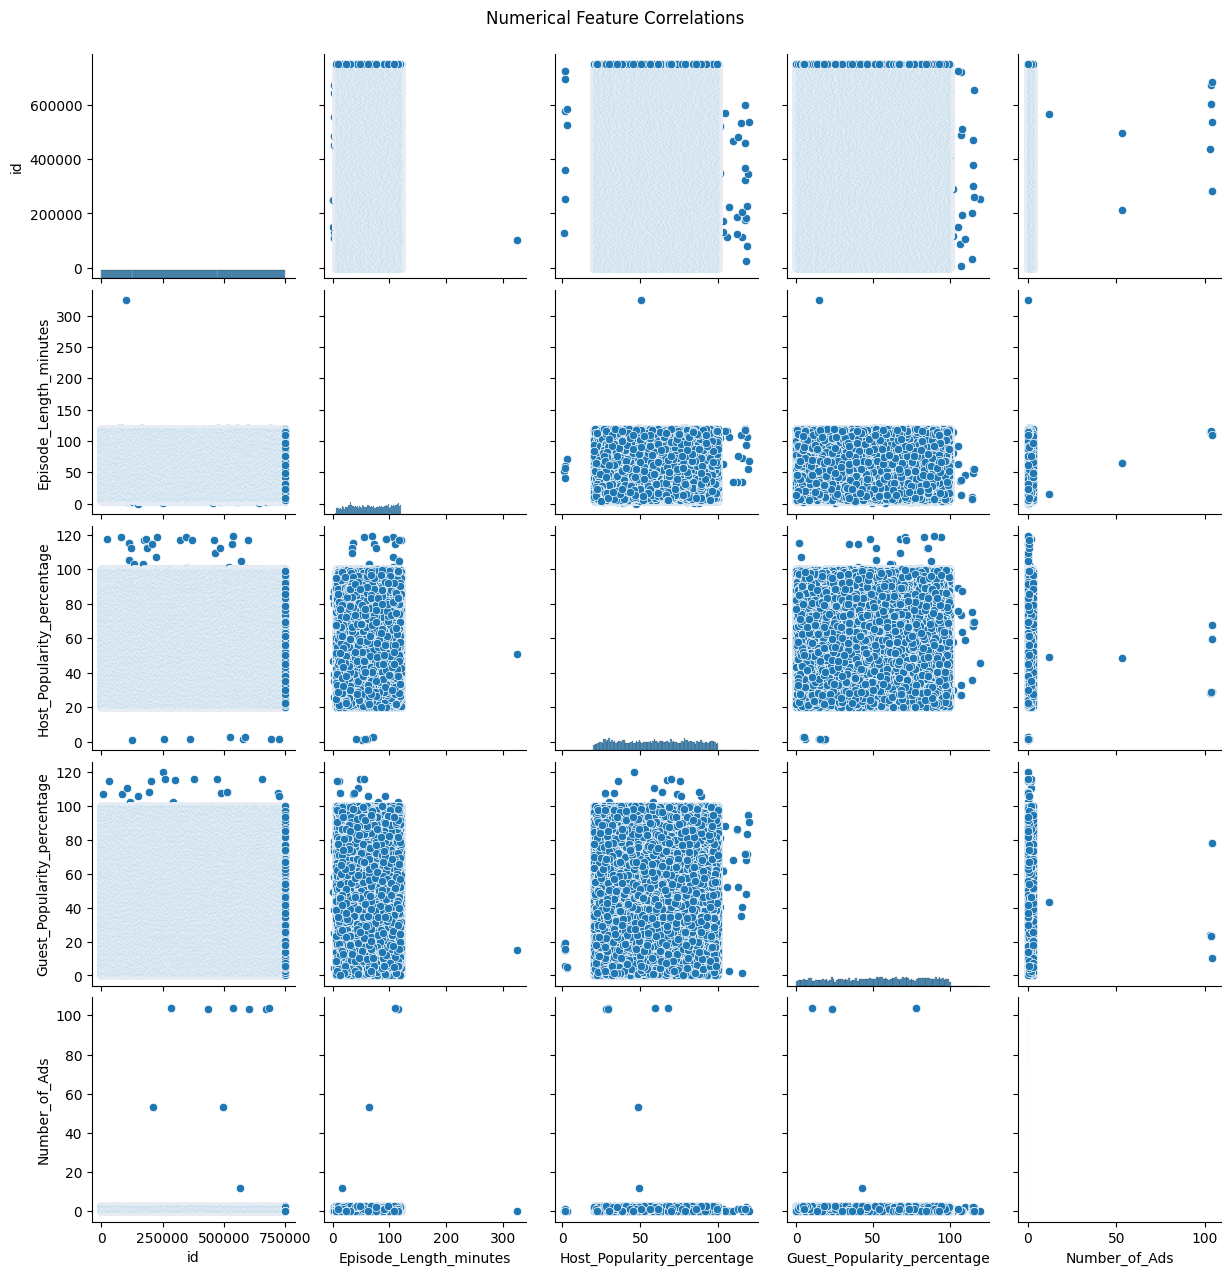

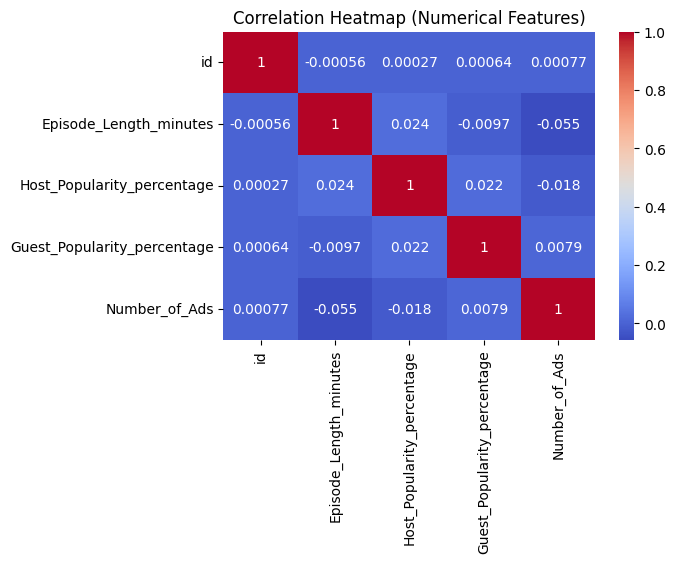

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt


# Pairplot to visualize relationships
sns.pairplot(train[numerical_features])
plt.suptitle("Numerical Feature Correlations", y=1.02)
plt.show()

# Heatmap of correlations
plt.figure(figsize=(6,4))
sns.heatmap(train[numerical_features].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()


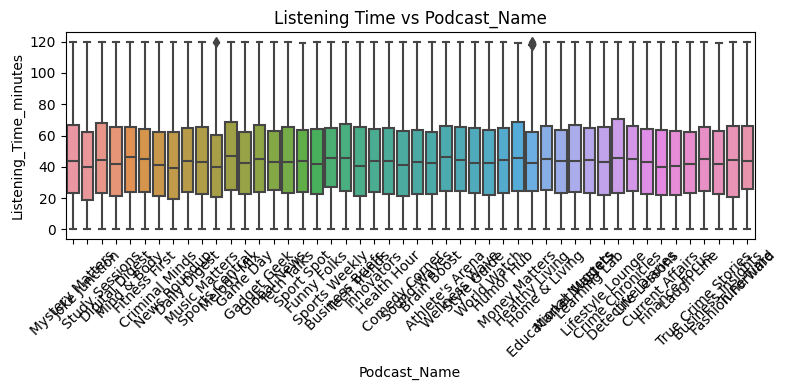

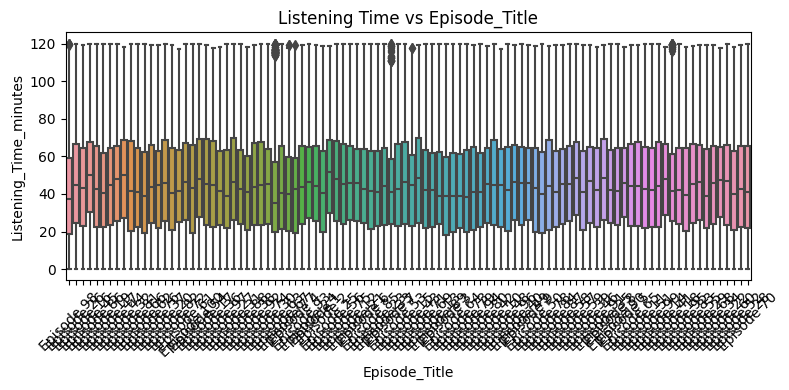

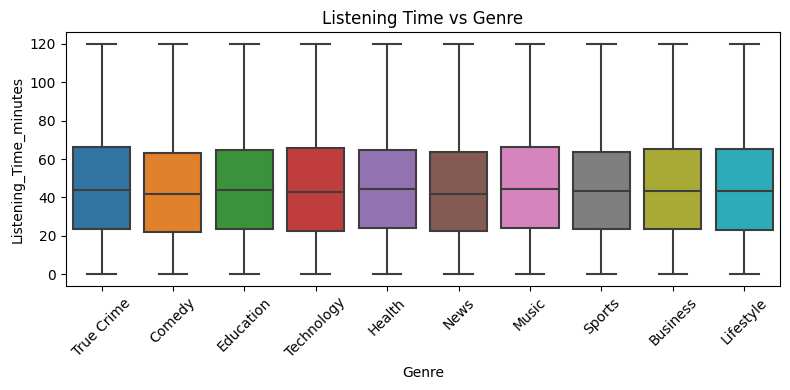

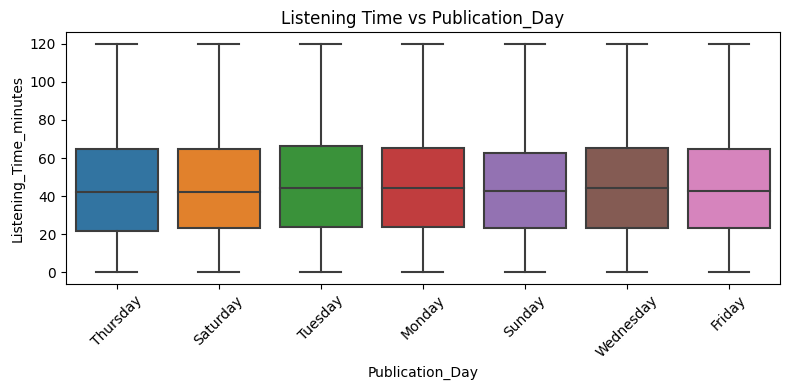

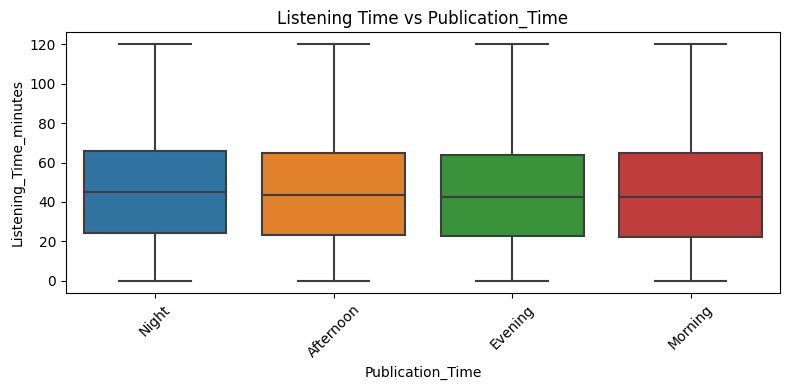

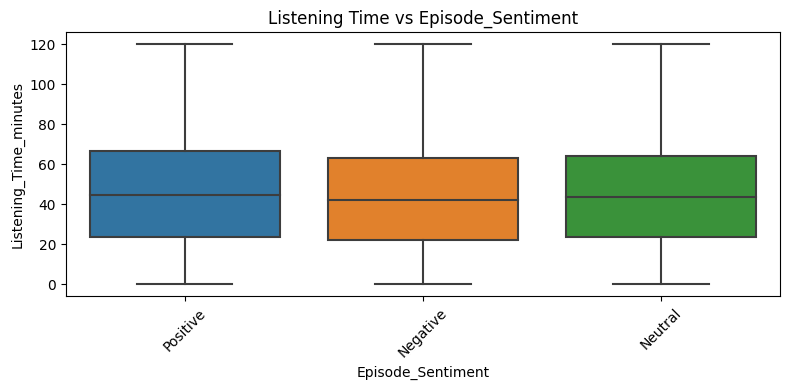

In [16]:


for col in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=col, y='Listening_Time_minutes', data=train)
    plt.title(f"Listening Time vs {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [17]:
def engineer_features(X_train, X_test):
    combined = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

    # 1. Ad Density
    combined['ads_per_minute'] = combined['Number_of_Ads'] / (combined['Episode_Length_minutes'] + 1e-3)

    # 2. Is Weekend
    combined['is_weekend'] = combined['Publication_Day'].isin(['Saturday', 'Sunday']).astype(int)

    # 3. Time of Day Features
    combined['is_morning'] = (combined['Publication_Time'] == 'Morning').astype(int)
    combined['is_night'] = (combined['Publication_Time'] == 'Night').astype(int)

    # 4. Episode Length Buckets
    combined['length_bucket'] = pd.cut(combined['Episode_Length_minutes'], bins=[0, 30, 60, 90, 200],
                                       labels=['short', 'medium', 'long', 'very_long'])

    # 5. Sentiment Ordinal Mapping
    sentiment_map = {'Negative': -1, 'Neutral': 0, 'Positive': 1}
    combined['sentiment_score'] = combined['Episode_Sentiment'].map(sentiment_map)

    # 6. Host-Guest Popularity Ratio
    combined['popularity_ratio'] = combined['Guest_Popularity_percentage'] / (
        combined['Host_Popularity_percentage'] + 1e-3)

    # 7. Episode Number from Title
    combined['episode_number'] = combined['Episode_Title'].str.extract(r'(\d+)').astype(float)

    # 8. Genre + Sentiment Interaction
    combined['genre_sentiment'] = combined['Genre'].astype(str) + "_" + combined['Episode_Sentiment'].astype(str)

    # --- Handle Missing Values ---
    # Fill numeric columns using Genre-wise mean
    for col in ['Episode_Length_minutes', 'Guest_Popularity_percentage']:
        combined[col] = combined.groupby('Genre')[col].transform(lambda x: x.fillna(x.mean()))

    # --- Encode Categorical Features ---
    categorical_cols = ['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day',
                        'Publication_Time', 'Episode_Sentiment', 'length_bucket', 'genre_sentiment']

    for col in categorical_cols:
        le = LabelEncoder()
        combined[col] = le.fit_transform(combined[col].astype(str))

    # Split back to train and test
    X_train_fe = combined.iloc[:len(X_train)].reset_index(drop=True)
    X_test_fe = combined.iloc[len(X_train):].reset_index(drop=True)

    return X_train_fe, X_test_fe


In [18]:
X_train_fe, X_test_fe = engineer_features(X_train, X_test)


In [19]:
X_train_fe

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,ads_per_minute,is_weekend,is_morning,is_night,length_bucket,sentiment_score,popularity_ratio,episode_number,genre_sentiment
0,0,34,98,63.84,9,74.81,4,3,53.58,0.0,2,0.000000,0,0,1,0,1,0.716205,98.0,29
1,1,24,19,119.80,1,66.95,2,0,75.95,2.0,0,0.016694,1,0,0,4,-1,1.134412,26.0,3
2,2,40,8,73.90,2,69.97,5,1,8.97,0.0,0,0.000000,0,0,0,0,-1,0.128196,16.0,6
3,3,10,40,67.17,8,57.22,1,2,78.70,2.0,2,0.029775,0,1,0,0,1,1.375369,45.0,26
4,4,31,85,110.51,3,80.07,1,0,58.68,3.0,1,0.027147,0,0,0,4,0,0.732850,86.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,26,18,75.66,2,69.36,2,2,53.58,0.0,0,0.000000,1,1,0,0,-1,0.772480,25.0,6
749996,749996,2,14,75.75,0,35.21,2,3,53.58,2.0,1,0.026402,1,0,1,0,0,1.521684,21.0,1
749997,749997,28,47,30.98,4,78.58,4,2,84.89,0.0,0,0.000000,0,1,0,1,-1,1.080287,51.0,12
749998,749998,41,42,108.98,4,45.39,4,2,93.27,0.0,0,0.000000,0,1,0,4,-1,2.054813,47.0,12


In [20]:
X_test_fe

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,ads_per_minute,is_weekend,is_morning,is_night,length_bucket,sentiment_score,popularity_ratio,episode_number,genre_sentiment
0,750000,11,71,78.96,2,38.11,2,1,53.33,1.0,1,0.012664,1,0,0,0,0,1.399334,73.0,7
1,750001,36,16,27.87,5,71.29,3,2,53.36,0.0,1,0.000000,1,1,0,3,0,0.748482,23.0,16
2,750002,24,3,69.10,1,67.89,0,1,97.51,0.0,2,0.000000,0,0,0,0,1,1.436273,11.0,5
3,750003,4,71,115.39,1,23.40,3,2,51.75,2.0,2,0.017332,1,1,0,4,1,2.211444,73.0,5
4,750004,27,46,72.32,4,58.10,6,2,11.30,2.0,1,0.027654,0,1,0,0,0,0.194489,50.0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,999995,31,2,21.05,3,65.77,2,1,96.40,3.0,0,0.142511,1,0,0,3,-1,1.465692,100.0,9
249996,999996,24,84,85.50,1,41.47,2,3,30.52,2.0,0,0.023392,1,0,1,0,-1,0.735936,85.0,3
249997,999997,24,60,12.11,1,25.92,4,1,73.69,1.0,1,0.082570,0,0,0,3,0,2.842869,63.0,4
249998,999998,29,41,113.46,0,43.47,0,3,93.59,3.0,2,0.026441,0,0,1,4,1,2.152930,46.0,2


In [21]:
X = X_train_fe.drop(['id'],axis=1)
y = y_train
test_id = X_test_fe['id']
test = X_test_fe.drop(['id'],axis=1)

In [22]:
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Best params from Optuna
best_params = {
    'n_estimators': 5000,
    'max_depth': 15,
    'learning_rate': 0.051564535401996674,
    'subsample': 0.6816345671807827,
    'colsample_bytree': 0.9977810444050708,
    'gamma': 1.4032650461122345,
    'reg_alpha': 2.7815627866713517,
    'reg_lambda': 3.780137117381534,
    'random_state': 42,
    'tree_method': 'gpu_hist',  
    'predictor': 'gpu_predictor'
}

# Initialize model
model = XGBRegressor(**best_params)

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rmse = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X), start=1):
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]
    
    model.fit(X_train_cv, y_train_cv, 
              eval_set=[(X_val_cv, y_val_cv)],
              early_stopping_rounds=50,
              verbose=False)
    
    preds = model.predict(X_val_cv)
    rmse_score = np.sqrt(mean_squared_error(y_val_cv, preds))
    cv_rmse.append(rmse_score)

    print(f"Fold {fold} RMSE: {rmse_score:.4f}")

print(f"\nAverage CV RMSE: {np.mean(cv_rmse):.4f}")

# Fit final model on all data
model.fit(X, y)


Fold 1 RMSE: 12.7092
Fold 2 RMSE: 12.7589
Fold 3 RMSE: 12.7410
Fold 4 RMSE: 12.7531
Fold 5 RMSE: 12.7049

Average CV RMSE: 12.7334


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9977810444050708, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=1.4032650461122345,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.051564535401996674,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5000, n_jobs=None,
             num_parallel_tree=None, predictor='gpu_predictor', ...)

<Figure size 1200x600 with 0 Axes>

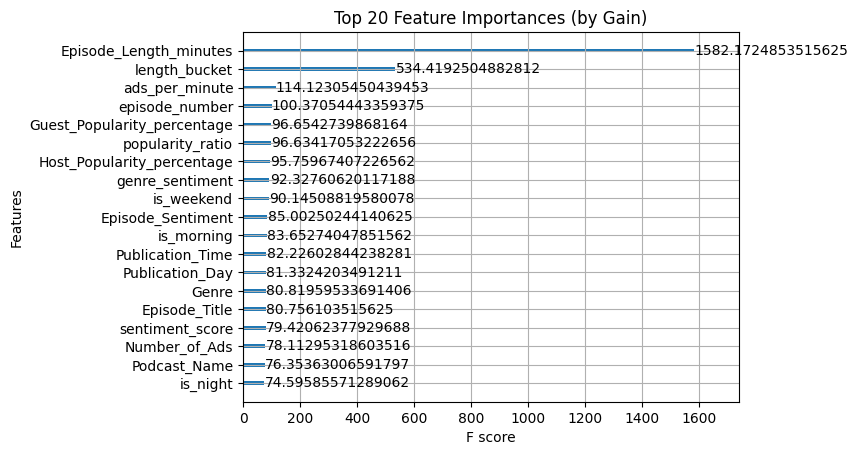

In [23]:
# Feature importance
plt.figure(figsize=(12, 6))
plot_importance(model, max_num_features=20, importance_type='gain')
plt.title("Top 20 Feature Importances (by Gain)")
plt.show()


In [24]:
test_preds = model.predict(test)


In [25]:

sub1 = pd.read_csv("/kaggle/input/ps-s5e4-listening-time-division-attention/submission.csv")
sub2= pd.read_csv("/kaggle/input/ps-s5-e4-ensemble-of-solutions/submission.csv")
sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e4/sample_submission.csv")

sample_submission['Listening_Time_minutes']= (0.51 * sub1['Listening_Time_minutes']) + (0.48 * sub2['Listening_Time_minutes'])+ (0.01*test_preds)

sample_submission.to_csv('submission.csv', index=False)
sample_submission.head()

,id,Listening_Time_minutes
0,750000,54.691033
1,750001,23.464620
2,750002,48.427960
3,750003,80.399217
4,750004,50.464971
